In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [2]:
import keras

import keras.layers as L

import keras.models as M

import tensorflow as tf

from PIL import Image

import matplotlib.pyplot as plt

import cv2

from keras.utils import Sequence

In [3]:
train=pd.read_csv('../input/handwriting-recognition/written_name_train_v2.csv')
validation=pd.read_csv('../input/handwriting-recognition/written_name_validation_v2.csv')


In [4]:
train.dropna(inplace=True)

In [5]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [6]:
train[train['IDENTITY']=='zucchi']

,FILENAME,IDENTITY
20507,TRAIN_20508.jpg,zucchi


In [7]:
train['Length']=train['IDENTITY'].apply(lambda x : len(str(x)))
train=train[train['Length']<=21]
train['IDENTITY']=train['IDENTITY'].str.upper()
train[train['Length']==max(train['Length'])]

,FILENAME,IDENTITY,Length
10278,TRAIN_10279.jpg,DOSSANTOS LASCONCELOS,21
108567,TRAIN_108568.jpg,O ZUARRDI EREBEVITRAC,21
156500,TRAIN_156501.jpg,ANDRIANNARISOA--DEGHI,21
160575,TRAIN_160576.jpg,LOUISIANE - EVANGELIN,21
174121,TRAIN_174122.jpg,GU ILLOSSOO - OARRIBA,21
212583,TRAIN_212584.jpg,DE MALEZIEUX DU HAMEL,21
220135,TRAIN_220136.jpg,COSTREL DE CORAINVILL,21
229529,TRAIN_229530.jpg,ROUSSEAV -- CHAUDIERE,21
230011,TRAIN_230012.jpg,BEKNARD DE LAVERNETTE,21
308769,TRAIN_308770.jpg,DATE NAISSANCE CLASSE,21


In [8]:
train=train.sample(frac=0.8,random_state=42)
validation=validation.sample(frac=0.1)

In [9]:
characters=set()
train['IDENTITY']=train['IDENTITY'].apply(lambda x: str(x))
for i in train['IDENTITY'].values:
    for j in i :
        if j not in characters :
            characters.add(j)
characters=sorted(characters)

In [10]:

# 2 Dictionaries  :   Turn all ur characters to num and vice versa
char_to_label = {char:label for label,char in enumerate(characters)}
label_to_char = {label:char for label,char in enumerate(characters)}

In [11]:
path_train='../input/handwriting-recognition/train_v2/train'
path_validation='../input/handwriting-recognition/validation_v2/validation'

In [12]:
# Data Generator
class DataGenerator(Sequence):
    def __init__(self,dataframe,path,char_map,batch_size=128,img_size=(256,64),
                 downsample_factor=4,max_length=22,shuffle=True):
        self.dataframe=dataframe
        self.path=path
        self.char_map=char_map
        self.batch_size=batch_size
        self.width=img_size[0]
        self.height=img_size[1]
        self.downsample_factor=downsample_factor
        self.max_length=max_length
        self.shuffle=shuffle
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.dataframe)//self.batch_size
    
    def __getitem__(self,idx):
        curr_batch_idx=self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images=np.ones((self.batch_size,self.width,self.height,1),dtype=np.float32)
        batch_labels=np.ones((self.batch_size,self.max_length),dtype=np.float32)
        input_length=np.ones((self.batch_size,1),dtype=np.float32)*(self.width//self.downsample_factor-2)
        label_length=np.zeros((self.batch_size,1),dtype=np.int64)
        for i,idx in enumerate(curr_batch_idx):
            img_path=self.dataframe['FILENAME'].values[idx]
            img=cv2.imread(self.path+'/'+img_path)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(self.width,self.height))
            img=(img/255).astype(np.float32)
            img=img.T
            img=np.expand_dims(img,axis=-1)
            text=self.dataframe['IDENTITY'].values[idx]
            text=str(text)
            label=[]
            for j in text: 
                if j in self.char_map :
                    label.append(self.char_map[j])
                else:
                    label.append(100)
            label.extend([100]*(22-len(label)))
            batch_images[i]=img
            batch_labels[i]=label
            label_length[i]=len(label)
        batch_inputs= {
                'input_data':batch_images,
                'input_label':batch_labels,
                'input_length':input_length,
                'label_length':label_length
                
            }
        return batch_inputs,np.zeros((self.batch_size),dtype=np.float32)
    def on_epoch_end(self):
        if self.shuffle == True :
            np.random.shuffle(self.indices)

In [13]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_validation,char_to_label)

In [14]:
# Making CTC Function
class CTCLayer(L.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # On test time, just return the computed loss
        return loss

In [15]:
# Making the Model now
def make_model():
    inp=L.Input(shape=(256,64,1),dtype=np.float32,name='input_data')
    labels=L.Input(shape=[22],dtype=np.float32,name='input_label')
    input_length=L.Input(shape=[1],dtype=np.int64,name='input_length')
    label_length=L.Input(shape=[1],dtype=np.int64,name='label_length')
    x=L.Conv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inp)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    x=L.Conv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x=L.MaxPooling2D(pool_size=(2,2))(x)
    x=L.Dropout(0.3)(x)
    new_shape=((256//4),(64//4)*128)
    x=L.Reshape(new_shape)(x)
    x=L.Dense(64,activation='relu')(x)
    x=L.Dropout(0.2)(x)
    x=L.Bidirectional(L.LSTM(128,return_sequences=True,dropout=0.2))(x)
    x=L.Bidirectional(L.LSTM(64,return_sequences=True,dropout=0.25))(x)
    x=L.Dense(len(characters)+1,activation='softmax',kernel_initializer='he_normal',name='Dense_output')(x)
    output=CTCLayer(name='outputs')(labels,x,input_length,label_length)
    model=M.Model([inp,labels,input_length,label_length],output)
    # Optimizer
    sgd = keras.optimizers.SGD(learning_rate=0.002,
                               decay=1e-6,
                               momentum=0.9,
                               nesterov=True,
                               clipnorm=5)
    model.compile(optimizer=sgd)
    return model

In [16]:
model=make_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 64, 64)  640         input_data[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 32, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 32, 64)  0           max_pooling2d[0][0]              
______________________________________________________________________________________________

In [17]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    history = model.fit(train_generator,steps_per_epoch=1000,validation_data=validation_generator,
                        epochs=8)

Epoch 1/8
1000/1000 [==============================] - 1105s 1s/step - loss: 23.3547 - val_loss: 18.9896
Epoch 2/8
1000/1000 [==============================] - 595s 595ms/step - loss: 18.5611 - val_loss: 16.0713
Epoch 3/8
1000/1000 [==============================] - 444s 444ms/step - loss: 15.3475 - val_loss: 9.2887
Epoch 4/8
1000/1000 [==============================] - 364s 364ms/step - loss: 9.5792 - val_loss: 5.5895
Epoch 5/8
1000/1000 [==============================] - 339s 338ms/step - loss: 6.5188 - val_loss: 3.9589
Epoch 6/8
1000/1000 [==============================] - 335s 335ms/step - loss: 5.0527 - val_loss: 3.0999
Epoch 7/8
1000/1000 [==============================] - 325s 325ms/step - loss: 4.1297 - val_loss: 2.6362
Epoch 8/8
1000/1000 [==============================] - 314s 314ms/step - loss: 3.6086 - val_loss: 2.3323


In [18]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='Dense_output').output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 64, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 32, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 32, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 32, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16, 128)       0   

In [19]:
if 'prediction_model_ocr.h5' not in os.listdir('./'):
    prediction_model.save('prediction_model_ocr.h5')
    prediction_model=M.load_model('prediction_model_ocr.h5')

In [20]:
label_to_char[100]=''

In [21]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += label_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

Ground truth: ALYSSA 	 Predicted: ALYSSA
Ground truth: HUGO 	 Predicted: NUGO
Ground truth: GAUTIER 	 Predicted: CAUTIER
Ground truth: DE CARUALHO 	 Predicted: DE CHRVALHO
Ground truth: CAPELLA 	 Predicted: CAPELLA
Ground truth: PIERRE 	 Predicted: PIERRE
Ground truth: PASINETTI 	 Predicted: PASTNETTT
Ground truth: OCEANE 	 Predicted: OCCONE
Ground truth: RAPHAEL 	 Predicted: BAPHOEI
Ground truth: LOU-ANNE 	 Predicted: LOU-ANNE
Ground truth: JEAN-MICHEL 	 Predicted: JEAN-MICHEL
Ground truth: LEONTE 	 Predicted: LEONIE
Ground truth: EMPTY 	 Predicted: MORANE
Ground truth: BOISDON 	 Predicted: BOISDON
Ground truth: WALTER 	 Predicted: WALTER
Ground truth: LHOMMELET 	 Predicted: LUOMMELET
Ground truth: HOUQUET 	 Predicted: MOUQUET
Ground truth: KAMAL 	 Predicted: KAMAL
Ground truth: DESUMEUR 	 Predicted: DESOMEUR
Ground truth: GAUNILLERE 	 Predicted: GAUDILLERE
Ground truth: MATHIS 	 Predicted: KATHIS
Ground truth: DIANE 	 Predicted: DIANE
Ground truth: NGUYEN 	 Predicted: NEUYEN
Ground t

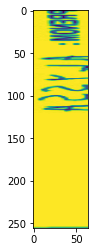

In [22]:
for p, (inp_value, _) in enumerate(validation_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    plt.imshow(X_data[0])
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([label_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Ground truth: {orig_texts[i]} \t Predicted: {pred_texts[i]}')
    break

Predicted Text: JULES


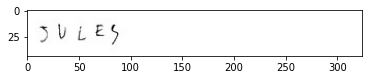

In [23]:
batch_images=np.ones((128,256,64,1),dtype=np.float32)
img=cv2.imread('../input/handwriting-recognition/test_v2/test/TEST_0004.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img=cv2.resize(img,(256,64))
img=(img/255).astype(np.float32)
img=img.T
img=np.expand_dims(img,axis=-1)
batch_images[0]=img
x=prediction_model.predict(batch_images)
pred_texts = decode_batch_predictions(x)
pred_texts = pred_texts[0]
im=cv2.imread('../input/handwriting-recognition/test_v2/test/TEST_0004.jpg')
plt.imshow(im)
print('Predicted Text:',pred_texts)